<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            40 non-null     object
 1   Product         40 non-null     object
 2   Units_Sold      40 non-null     int64 
 3   Price_per_Unit  40 non-null     int64 
 4   Sales           40 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.7+ KB
Highest revenue day: 2025-01-08 with amount: $127321
Total sales: $806297
Total profit: $201574.25
Total sales per product:
Product
Headphones    146898
Laptop        120713
Phone         199853
Tablet        338833
Name: Sales, dtype: int64


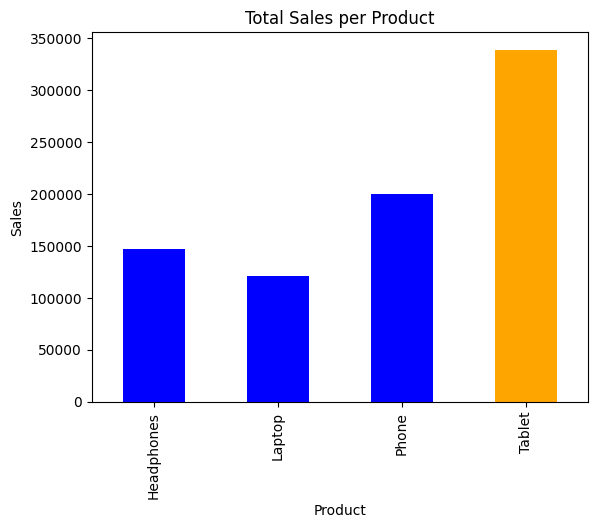

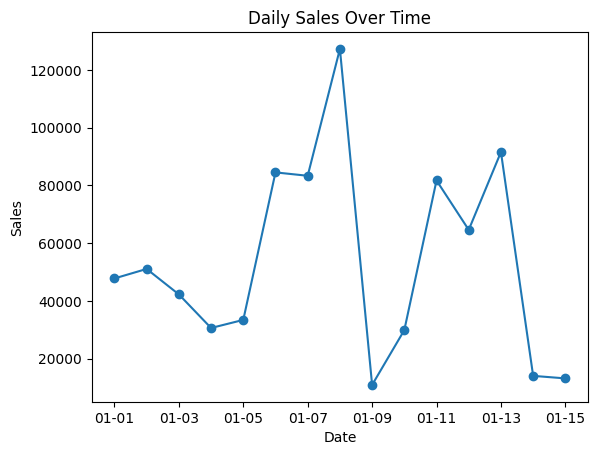

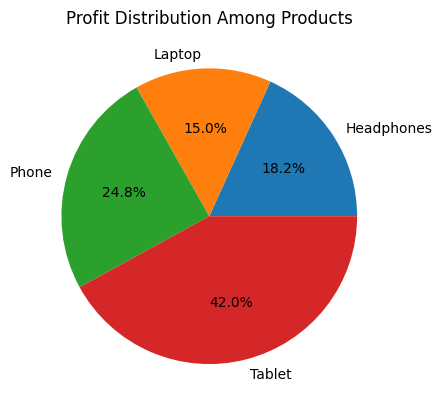

Predicted sales for the next 5 days: [51398.12058408 50985.28026378 50572.43994348 50159.59962317
 49746.75930287]


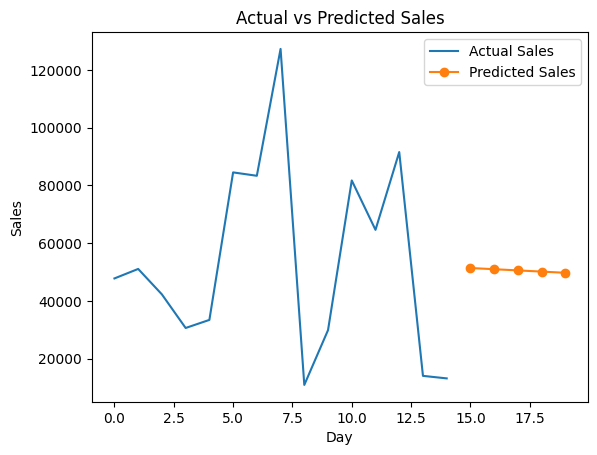

R² score: -0.02478027365510105
Mean Absolute Error (MAE): 30705.454702465067
Root Mean Squared Error (RMSE): 32772.44792657963
Multi-feature R²: -0.7287017270751108
Multi-feature MAE: 33271.276296724005
Multi-feature RMSE: 42565.088092479375
Predicted sales for next 5 days (multi-feature): [79516.30147108 80627.22790525 81738.15433942 82849.08077359
 83960.00720776]


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df= pd.read_csv('medium_sales.csv')
df.head()
df.info() and df.describe()

# we want to find revenue for each day and then 
# find the day with the highest revenue in the month
# and then check profits for each day by comparing to last day
daily_sales = df.groupby("Date")["Sales"].sum()
profits = daily_sales.diff().fillna(0)
# highest revenue day
highest_revenue_day = daily_sales.idxmax()
# highest revenue amount
highest_revenue_amount = daily_sales.max()
# printed results
print(f"Highest revenue day: {highest_revenue_day} with amount: ${highest_revenue_amount}")
# if profit is at 25% overall then:
df["Profit"] = df["Sales"] * 0.25
total_profit = df["Profit"].sum()
total_sales = df["Sales"].sum()
total_sales_per_product = df.groupby("Product")["Sales"].sum()
total_profit_per_product = df.groupby("Product")["Profit"].sum()
avg_units_per_product = df.groupby("Product")["Units_Sold"].mean()
# printed results
print(f"Total sales: ${total_sales}")
print(f"Total profit: ${total_profit}")
print("Total sales per product:")
print(total_sales_per_product)

#lets create some visualizations

# best selling product - graph blue is best selling, orange is others
best_selling_product = total_sales_per_product.idxmax()
colors = ['blue' if product != best_selling_product else 'orange' for product in total_sales_per_product.index]
total_sales_per_product.plot(kind='bar', color=colors, title='Total Sales per Product')
plt.ylabel('Sales')
plt.show()

# Ensure dates are sorted
daily_sales = daily_sales.sort_index()

# Plot line chart for daily sales over time
daily_sales.index = pd.to_datetime(daily_sales.index).strftime('%m-%d')
daily_sales.plot(kind='line', marker='o', title='Daily Sales Over Time')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Pie chart for profit distribution among the products:
total_profit_per_product.plot(kind='pie', autopct='%1.1f%%', title='Profit Distribution Among Products')
#remove y label
plt.ylabel('')
plt.show()


# Moving on to predict sales for the next 5 days using linear regression !
x=np.array(range(len(daily_sales))).reshape(-1, 1)  # Days as a feature - array of days (0, 1, 2, ...)
y=daily_sales.values  # Sales as the target variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# Predict sales for the next 5 days
future_days = np.array(range(len(daily_sales), len(daily_sales) + 5)).reshape(-1, 1)
future_sales_pred = model.predict(future_days)
print("Predicted sales for the next 5 days:", future_sales_pred)
 
 # we can also graph the predictions with actual sales
plt.plot(range(len(daily_sales)), y, label='Actual Sales')
plt.plot(range(len(daily_sales), len(daily_sales) + 5), future_sales_pred, label='Predicted Sales', marker='o')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()
# prediction doesnt doesnt seem to be very accurate but its a start i guess

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print("R² score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# yet it isnt very accurate - R² score is negative ...
# we can try to improve it :

# Aggregate daily metrics
daily_units = df.groupby("Date")["Units_Sold"].sum()
daily_price = df.groupby("Date")["Price_per_Unit"].mean()

# Create multi-feature DataFrame
X_multi = pd.DataFrame({
    "Day": range(len(daily_sales)),        # 0, 1, 2, ...
    "Units_Sold": daily_units.values,
    "Avg_Price": daily_price.values
})

y_multi = daily_sales.values  # Target: total sales per day


# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=28)

# Train model
model_multi = LinearRegression()
model_multi.fit(x_train, y_train)

# Predict on test set
y_pred_multi = model_multi.predict(x_test)

# Evaluate
r2_multi = r2_score(y_test, y_pred_multi)
mae_multi = mean_absolute_error(y_test, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))

print("Multi-feature R²:", r2_multi)
print("Multi-feature MAE:", mae_multi)
print("Multi-feature RMSE:", rmse_multi)

last_units = daily_units.values[-1]
last_price = daily_price.values[-1]

future_days_multi = pd.DataFrame({
    "Day": range(len(daily_sales), len(daily_sales) + 5),
    "Units_Sold": [last_units]*5,
    "Avg_Price": [last_price]*5
})

future_sales_pred_multi = model_multi.predict(future_days_multi)
print("Predicted sales for next 5 days (multi-feature):", future_sales_pred_multi)

# I think its worse now - R² is even more negative... 
# maybe a non-linear model would work better but i dont want to overcomplicate things
# Maybe i will gather new data unlike generated one and try again later
# At least I got the visualizations done and some basic analysis hehe


